In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""
    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)

    # Extracting features from the test data using the same vectorizer
    X_test = vectorizer.transform(data_test.data)

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        print(f"{len(data_train.data)} documents")
        print(f"{len(data_test.data)} documents")
        print(f"{len(target_names)} categories")
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose=True)

2034 documents
1353 documents
4 categories
n_samples: 2034, n_features: 7831
n_samples: 1353, n_features: 7831


top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


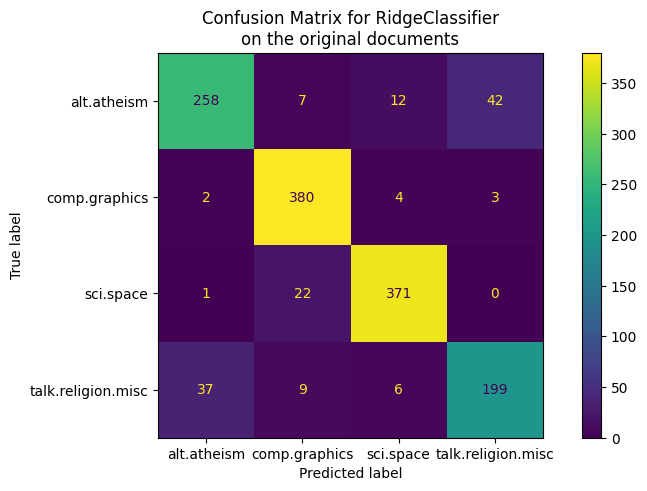

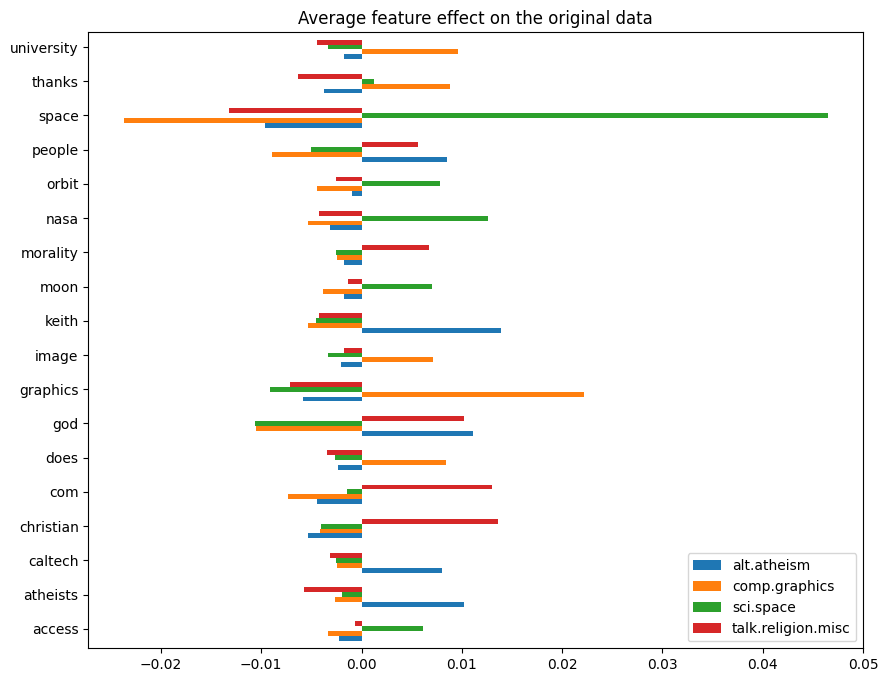

In [2]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax

_ = plot_feature_effects().set_title("Average feature effect on the original data")

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


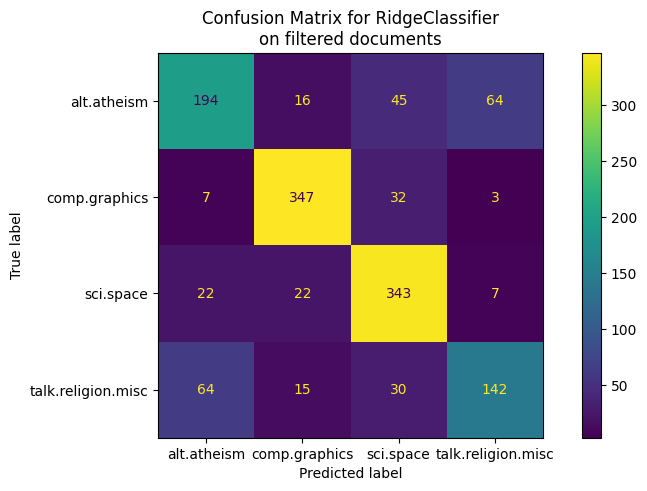

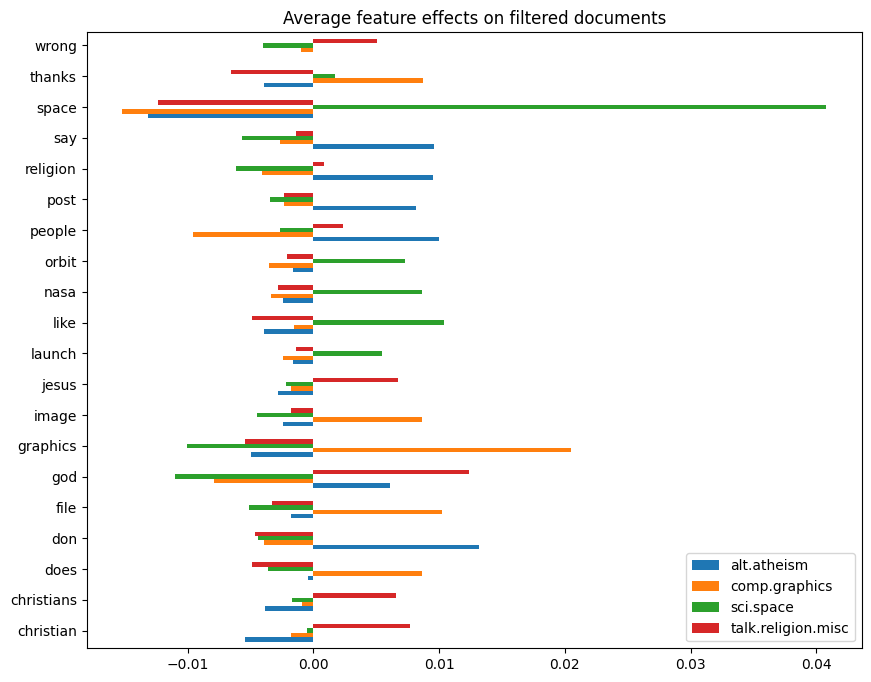

In [3]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

_ = plot_feature_effects().set_title("Average feature effects on filtered documents")

Logistic Regression
Training Logistic Regression...
Predicting Logistic Regression...
Accuracy: 0.7724
Training time: 0.1043s
Test time: 0.0004s
--------------------------------------------------------------------------------
Ridge Classifier
Training Ridge Classifier...
Predicting Ridge Classifier...
Accuracy: 0.7598
Training time: 0.0126s
Test time: 0.0004s
--------------------------------------------------------------------------------
kNN
Training kNN...
Predicting kNN...
Accuracy: 0.7524
Training time: 0.0003s
Test time: 0.0558s
--------------------------------------------------------------------------------
Random Forest
Training Random Forest...
Predicting Random Forest...
Accuracy: 0.7007
Training time: 0.4566s
Test time: 0.0425s
--------------------------------------------------------------------------------
Linear SVC
Training Linear SVC...
Predicting Linear SVC...
Accuracy: 0.7517
Training time: 0.0181s
Test time: 0.0005s
-----------------------------------------------------

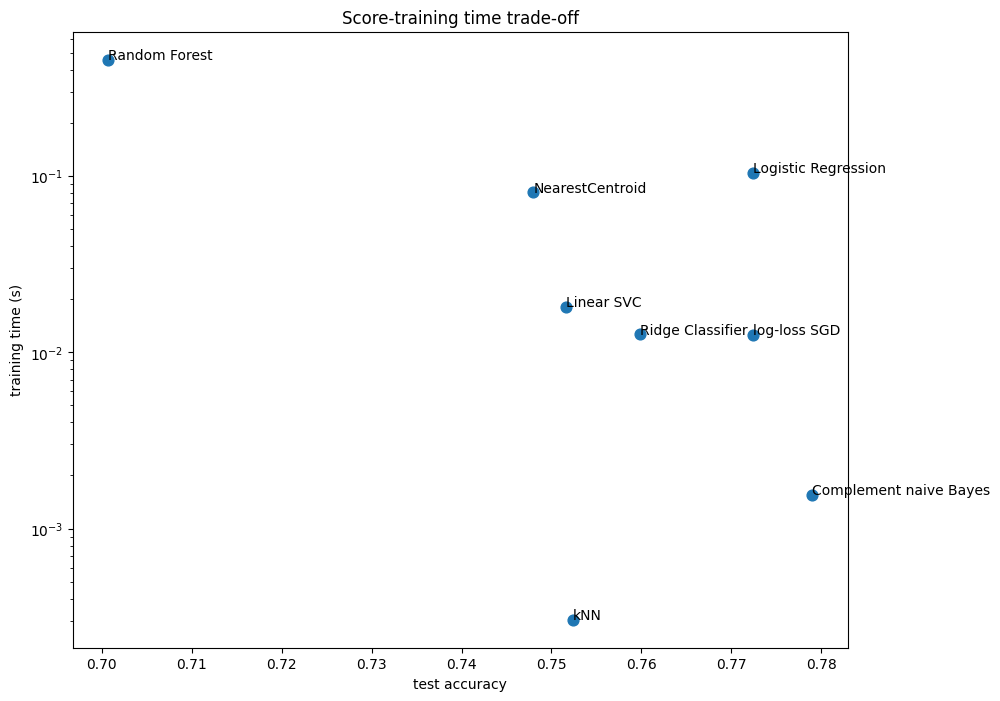

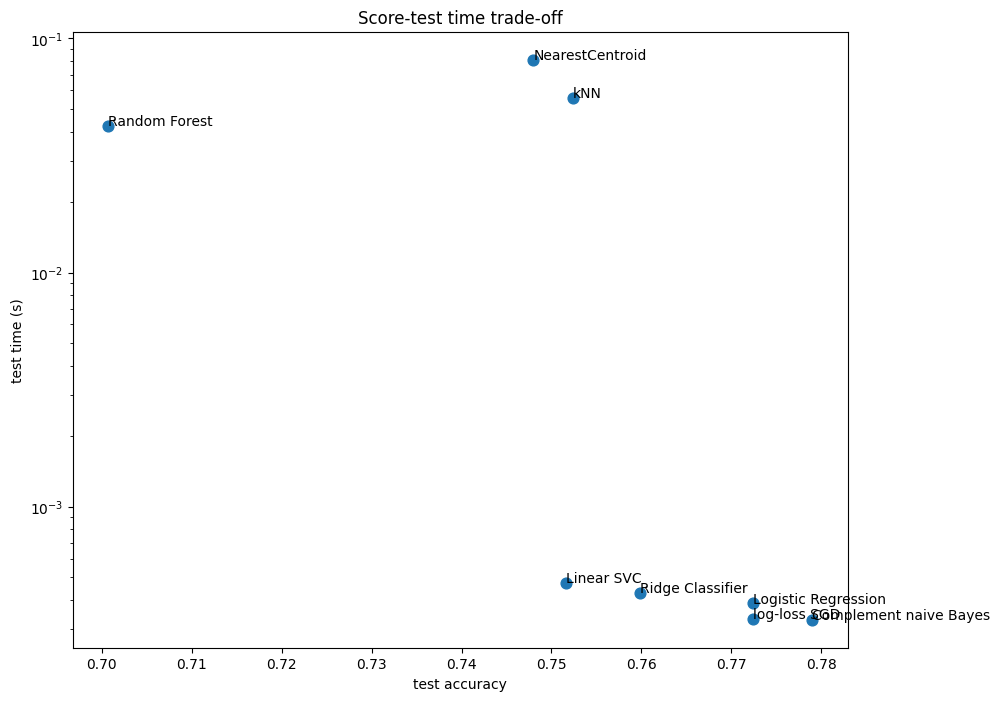

In [4]:
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

import time

def benchmark(clf, name):
    print(f"Training {name}...")
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0

    print(f"Predicting {name}...")
    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0

    score = metrics.accuracy_score(y_test, pred)
    print(f"Accuracy: {score:.4f}")
    print(f"Training time: {train_time:.4f}s")
    print(f"Test time: {test_time:.4f}s")
    print("-" * 80)
    return name, score, train_time, test_time


results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))